__система машинного перевода, модель SEQ2SEQ__ 

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()
np.set_printoptions(precision=2)

# загружаем данные

https://drive.google.com/file/d/166Msc4oTDy2wFWd5_VnuZES3dduvpMD1/view?usp=share_link

In [2]:
# %%time 

# import zipfile
# import requests
# from io import StringIO,BytesIO

# file_id = '166Msc4oTDy2wFWd5_VnuZES3dduvpMD1'
# url = f'https://drive.google.com/uc?id={file_id}'

# with requests.get(url,stream=True) as r:
#     with zipfile.ZipFile(BytesIO(r.content)) as z:
#         with z.open('Rus-Eng-small.tsv') as f:
#             df = pd.read_csv( 
#                 StringIO( str(f.read(),encoding='utf-8' )[1:] ), 
#                 sep='\t',
#                 header=None,
#                 names=['N_Rus','Rus','N_Eng','Eng'] 
#             )


In [3]:
df = pd.read_pickle('../data/mt-en-ru.pkl.gz')

In [4]:
display(len(df))
display(df.sample(10))

200000

,N_Rus,Rus,N_Eng,Eng
71283,2608737,Я ассистент.,2247922,I'm an assistant.
153401,3788744,"Не прогуливай занятия, хорошо?",3786134,"Don't skip classes, okay?"
21392,939612,Кино вот-вот начнётся.,939608,The movie's about to start.
6279,439035,Куда они идут прямо сейчас?,408261,Where are they going to right now?
103756,3059131,Это не порно - это искусство.,1641939,"It's not porn, it's art."
155287,3839205,"Не знаю, что с этим делать.",2318328,I don't know what to do about it.
33780,1655040,Сколько стоит этот диван?,1255286,How much does this sofa cost?
53113,2385862,Это предложение содержит в себе семь слов.,589768,This sentence has seven words in it.
107613,3109388,Эта популярная немецкая певица поёт только на ...,3109375,This popular German singer only sings in English.
162019,3940281,Том что-то смотрит по телевизору.,2642356,Tom is watching something on TV.


In [5]:
display( df.info() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   N_Rus   200000 non-null  int64 
 1   Rus     200000 non-null  object
 2   N_Eng   200000 non-null  int64 
 3   Eng     200000 non-null  object
dtypes: int64(2), object(2)
memory usage: 6.1+ MB


None

In [6]:
# df.to_pickle('tmp/data.pkl')

In [7]:
display( len(df) )
df = df.drop_duplicates('N_Rus').drop_duplicates('N_Eng').reset_index(drop=True)
display( len(df) )

200000

147087

# выбираем пары для обучения модели

## анализ словаря

In [8]:
# !pip install razdel

In [9]:
from razdel import tokenize
from nltk.tokenize import word_tokenize as nltk_tokenize_word

In [10]:
# CountVectorizer(
#     *, 
#     input='content', 
#     encoding='utf-8', 
#     decode_error='strict', 
#     strip_accents=None, 
#     lowercase=True, 
#     preprocessor=None, 
#     tokenizer=None, 
#     stop_words=None, 
#     token_pattern='(?u)\b\w\w+\b', 
#     ngram_range=(1, 1), 
#     analyzer='word', 
#     max_df=1.0, 
#     min_df=1, 
#     max_features=None, 
#     vocabulary=None, 
#     binary=False, 
#     dtype=<class 'numpy.int64'>
# )

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from razdel import tokenize

In [12]:
import re

df['Rus'] = df['Rus'].progress_apply(lambda s: re.sub(r'[«»]','"',s))

  0%|          | 0/147087 [00:00<?, ?it/s]

In [13]:
def tokenizer_ru(s): return [ t.text for t in tokenize(s) ] 

cv_ru = CountVectorizer(
        lowercase=False,
        token_pattern=None,
        tokenizer=tokenizer_ru, 
        min_df=2,
    ).fit(df['Rus'])

vocab_ru = cv_ru.vocabulary_
display( len(vocab_ru) )

vocab_ru_ = (
    pd.DataFrame(
        [ [v,k] for k,v in  vocab_ru.items() ],columns=['index','word']
    )
        .sort_values(by='index')
        .set_index('index')
    )
vocab_ru_['tf'] = cv_ru.transform(df['Rus']).sum(axis=0).T

display( vocab_ru_ )

# vocab_ru_.sort_values(by='tf').to_csv('tmp/vocab_ru.csv',index=False,sep='\t')

display( vocab_ru_[['tf']].describe([.01, .25, .75, .95, .99 ]).T )

29472

,word,tf
index,,
0,!,3818
1,!!!,5
2,!..,3
3,"""",4745
4,$,3
...,...,...
29467,“,9
29468,”,5
29469,„,4


,count,mean,std,min,1%,25%,50%,75%,95%,99%,max
tf,29472.0,34.5985,864.259552,2.0,2.0,2.0,4.0,9.0,61.0,324.58,126855.0


In [14]:
# vocab_ru_.query('tf<2').sort_values(by='tf')

In [15]:
# vocab_ru_.query('tf>188').sort_values(by='tf')

In [25]:
del vocab_ru_

---

In [16]:
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.tokenize import word_tokenize as nltk_tokenize_word

def tokenizer_en(s): return nltk_tokenize_word(s,language='english') 

cv_en = CountVectorizer(
        lowercase=False,
        token_pattern=None,
        tokenizer=tokenizer_en, 
        min_df=2,
    ).fit(df['Eng'])

vocab_en = cv_en.vocabulary_
display( len(vocab_en) )

vocab_en_ = (
    pd.DataFrame(
        [ [v,k] for k,v in  vocab_en.items() ],columns=['index','word']
    )
        .sort_values(by='index')
        .set_index('index')
    )

vocab_en_['tf'] = cv_en.transform(df['Eng']).sum(axis=0).T

display( vocab_en_ )

# vocab_en_.sort_values(by='tf').to_csv('tmp/vocab_en.csv',index=False,sep='\t')

display( vocab_en_[['tf']].describe([.01, .25, .75, .95, .99 ]).T )

13494

,word,tf
index,,
0,!,3397
1,$,37
2,%,56
3,&,3
4,',207
...,...,...
13489,—,45
13490,‘,23
13491,’,103


,count,mean,std,min,1%,25%,50%,75%,95%,99%,max
tf,13494.0,88.466726,1370.468131,2.0,2.0,3.0,5.0,17.0,168.0,1119.35,127460.0


In [25]:
del vocab_en_

## выделяем тестовый набор

In [17]:
# считаем количество слов
df['Rus_len_seq'] = df['Rus'].progress_apply(lambda s: len( tokenizer_ru(s) )  )
df['Eng_len_seq'] = df['Eng'].progress_apply(lambda s: len( tokenizer_en(s) ) )
display( df[['Rus_len_seq','Eng_len_seq']].describe().astype(int).T )

  0%|          | 0/147087 [00:00<?, ?it/s]

  0%|          | 0/147087 [00:00<?, ?it/s]

,count,mean,std,min,25%,50%,75%,max
Rus_len_seq,147087,7,4,2,5,6,8,173
Eng_len_seq,147087,8,4,2,6,7,9,232


In [18]:
l_min,l_max = 3,10

# выбираем последовательности приблизительно одинаковой длинны
df_train = df.query(f'({l_min}<Rus_len_seq<{l_max})&({l_min}<Eng_len_seq<{l_max})')
display( len(df_train) )
display( df_train.sample(7) )

103883

,N_Rus,Rus,N_Eng,Eng,Rus_len_seq,Eng_len_seq
144581,3301129,Он закатал рукава рубашки.,4308777,He rolled up his shirt sleeves.,5,7
15787,750984,Она в ванной.,456721,She is in the bathroom.,4,6
127385,4020185,"Я хочу, чтобы его избили.",3904814,I want him beaten up.,7,6
87958,1834863,Вот мой дом.,955157,This is my house.,4,5
76786,3012779,Том протянул Мэри книгу.,1028783,Tom handed Mary a book.,5,6
14387,653157,Я пошлю книгу по почте.,43849,I'll send the book by mail.,6,8
145120,4347525,Не забудь написать индекс.,4198352,Don't forget to write the zip code.,5,9


In [19]:
df_test = df_train.sample( len(df_train)//10 )
df_train = df_train.drop(df_test.index)

df_val = df_train.sample( len(df_train)//10 )
df_train = df_train.drop(df_val.index)

display( len(df_train), len(df_val), len(df_test) )

84146

9349

10388

# собираем генератор датасета

In [20]:
# vocab_en

In [22]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [23]:
class TextPairDataset(Dataset):

    def __init__(self, df,vocab,cols={'Rus':'russian','Eng':'english'}):
        super().__init__()

        assert len(cols)==2
        assert len(df)>1
        self._lang = cols
        self._data = df[self._lang.keys()].reset_index(drop=True)
        # self._vocab = vocab if vocab
        #         else { k : self._make_vocab(df[k],language=self._lang[k]) for k in self._lang } 
        self._vocab = vocab 
        self._max_seq = { k : self._get_max_seq(df[k],language=self._lang[k]) for k in self._lang }
    
    @staticmethod
    def  _tokenize(s,language):
        return nltk_tokenize_word(s,language=language)

#     @classmethod
#     def _make_vocab(cls,d,language):
#         words = sorted(set.union(*[ set(  cls._tokenize(s,language) ) for s in tqdm(d) ]))
#         return { w:n+1 for n,w in enumerate(words) } | { '<PAD>':0, '<EOS>':len(words)+2, '<UNK>':len(words)+3 }
    
    @classmethod
    def _get_max_seq(cls,d,language):
        return max([ len(cls._tokenize(s,language)) for s in tqdm(d) ])
    
    @property
    def vocab(self):
        return self._vocab

    @vocab.setter
    def vocab(self,vocab):
        self._vocab = vocab

    @property
    def data(self):
        return self._data
        
    def __len__(self):
        return len(self._data)
    
    @property
    def max_seq(self):
        return self._max_seq
    
    def _encode(self,s,language,vocab):
        return [ vocab['<UNK>'] if not(w in vocab) else vocab[w] for w in self._tokenize(s,language) ] 
        
    def _pad_seq(self,s,max_seq,eos_code):
        return [0]*(max_seq-len(s)) + s + [eos_code]
    
    def __getitem__(self, idx):
        return  [
            torch.LongTensor(
                    np.array(
                        self._pad_seq(
                            self._encode( self._data[c][idx], language=self._lang[c] , vocab=self._vocab[c] ) 
                            ,max_seq=self._max_seq[c]
                            ,eos_code=self._vocab[c]['<EOS>']
                        ) 
                        ,dtype=int
                    )
            )
            for c in self._lang 
        ]

----

In [24]:
vocab_ru = { w:n+1 for n,w in enumerate(sorted(vocab_ru.keys())) }
ru_max_idx = max(vocab_ru.values())
vocab_ru =  vocab_ru | { '<PAD>':0, '<EOS>':ru_max_idx+1, '<UNK>':ru_max_idx+2, }
display( len(vocab_ru) )

del ru_max_idx

29475

In [26]:
vocab_en = { w:n+1 for n,w in enumerate(sorted(vocab_en.keys())) }
en_max_idx = max(vocab_en.values())
vocab_en =  vocab_en | { '<PAD>':0, '<EOS>':en_max_idx+1, '<UNK>':en_max_idx+2, }
display( len(vocab_en) )
del en_max_idx

13497

In [27]:
vocab = { 'Rus': vocab_ru, 'Eng': vocab_en, }

In [28]:
del vocab_ru
del vocab_en

---

In [29]:
ds_train = TextPairDataset( df_train, vocab=vocab )

  0%|          | 0/84146 [00:00<?, ?it/s]

  0%|          | 0/84146 [00:00<?, ?it/s]

In [30]:
ds_val = TextPairDataset(df_val, vocab=ds_train.vocab)

  0%|          | 0/9349 [00:00<?, ?it/s]

  0%|          | 0/9349 [00:00<?, ?it/s]

In [31]:
display( ds_train.max_seq, ds_val.max_seq )

{'Rus': 9, 'Eng': 9}

{'Rus': 9, 'Eng': 9}

In [32]:
# for input_tensor, target_tensor in DataLoader( ds_train, batch_size=3, shuffle=True): 
#     break

# display( input_tensor, target_tensor )

In [33]:
# with torch.set_grad_enabled(False):
#     o,h = model_encoder(t0)
#     r  = model_decoder(encoder_outputs=o,encoder_hidden=h)

# строим модель

In [34]:
import torch.nn as nn
import torch.nn.functional as F

In [35]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim, encoder_hidden_dim,): 
        super(Encoder, self).__init__()
        self._emb = nn.Embedding(vocab_len, embedding_dim)
        self._rnn = nn.GRU(
                input_size=embedding_dim, 
                hidden_size=encoder_hidden_dim, 
                num_layers=2, 
                batch_first=True,
                dropout=0.4,
            )

    def forward(self, x):
        o = self._emb(x)
        o, h = self._rnn(o)
        return o,h

In [36]:
# vocab_len = len(ds.vocab['Rus'])
# embedding_dim = 256
# encoder_hidden_dim = 128

# model_encoder = Encoder(
#         vocab_len=vocab_len+1,
#         embedding_dim=embedding_dim,
#         encoder_hidden_dim=encoder_hidden_dim,
#     )

# with torch.set_grad_enabled(False):
#     o,h = model_encoder(t0)
    
# display( o.shape, h.shape )

In [37]:
# torch.empty(3, 1, dtype=torch.long).fill_(0)

In [38]:
class Decoder(nn.Module):
    
    def __init__(self, hidden_size, output_size, max_seq_len, device='cpu'):
        super(Decoder, self).__init__()
        self._emb = nn.Embedding(num_embeddings=output_size, embedding_dim=hidden_size)
        self._rnn = nn.GRU( 
                input_size=hidden_size, 
                hidden_size=hidden_size, 
                num_layers=2, 
                batch_first=True,
                dropout=0.4,
            )
        self._lin = nn.Linear(in_features=hidden_size, out_features=output_size, bias=True,)
        #self._dp = nn.Dropout(0.1)
        self._device = device
        self._max_seq_len = max_seq_len

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=self._device).fill_(0)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(self._max_seq_len):
            decoder_output, decoder_hidden  = self._forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def _forward_step(self,x,hidden):
        o = F.relu( self._emb(x) )
        o,h = self._rnn(o, hidden)
        # o = self._dp( self._lin(o) )
        o = self._lin(o)
        return o,h

----

In [39]:
# # проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device='cpu'
display( device )

device(type='cuda', index=0)

In [40]:
vocab_input_len  = len(ds_train.vocab['Rus'])
vocab_output_len = len(ds_train.vocab['Eng'])
max_output_seq_len = ds_train.max_seq['Eng']+1

In [41]:
embedding_dim = 1024
encoder_hidden_dim = 256

model_encoder = Encoder(
        vocab_len=vocab_input_len+1,
        embedding_dim=embedding_dim,
        encoder_hidden_dim=encoder_hidden_dim,
    ).to(device)

model_decoder = Decoder( 
        hidden_size=encoder_hidden_dim, 
        output_size=vocab_output_len+1, 
        max_seq_len=max_output_seq_len,
        device=device,
    ).to(device)

In [42]:
display( vocab_input_len, vocab_output_len )

29475

13497

In [43]:
display( max(ds_train.vocab['Rus'].values()),  max(ds_train.vocab['Eng'].values()) )

29474

13496

In [ ]:
# with torch.set_grad_enabled(False):
#     o,h = model_encoder(t0)
#     r  = model_decoder(encoder_outputs=o,encoder_hidden=h)

# r[0].shape, r[1].shape, # r[3].shape

In [ ]:
# r[0].view(-1, r[0].size(-1)).shape
# r[0].shape ,  t1.shape

In [ ]:
# display( r[0].view(-1, r[0].size(-1)).shape )
# display( t1.view(-1).shape )

In [ ]:
# criterion = nn.NLLLoss()
# with torch.set_grad_enabled(False):    
#     loss = criterion(
#             r[0].view(-1, r[0].size(-1)),
#             t1.view(-1)
#         )
# loss.item()

# обучаем 

In [44]:
from torch import optim

learning_rate = 1e-3
encoder_optimizer = optim.Adam( model_encoder.parameters(), lr=learning_rate )
decoder_optimizer = optim.Adam( model_decoder.parameters(), lr=learning_rate )
criterion = nn.NLLLoss()

In [45]:
display( len(ds_train) )

84146

In [46]:
# with torch.set_grad_enabled(False):
#     for input_tensor, target_tensor in DataLoader( ds, batch_size=3, shuffle=True): 
#         encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
#         decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
#         break

# decoder_outputs

In [47]:
# encoder_outputs
# encoder_hidden

In [48]:
loss_history_train = [] # значения ф-ции потери
loss_history_val = [] # значения ф-ции потери

In [49]:
%%time

n_epoch = 64 # количество эпох обучения
batch_size = 512*3

lag_val_check = 4
n_iter_no_check = n_epoch*0.33

assert n_iter_no_check>lag_val_check

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    
    # получаем батч учебных примеров
    for input_tensor, target_tensor in DataLoader( ds_train, batch_size=batch_size, shuffle=True): 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.to(device).view(-1)
        )
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
   
    loss_history_train.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    
    
    loss_batch = []
    with torch.set_grad_enabled(False):   
        # получаем батч проверочных примеров
        for input_tensor, target_tensor in DataLoader( ds_val, batch_size=batch_size, shuffle=False): 
            encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
            decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.to(device).view(-1)
            )
            loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче

    loss_history_val.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери

    if i>n_iter_no_check:
        if ( loss_history_val[-lag_val_check]<loss_history_val[-1] ):
            print( 'validation loss value up, stoped\n' )
            break

  0%|          | 0/64 [00:00<?, ?it/s]

validation loss value up, stoped

CPU times: user 10min 31s, sys: 1.18 s, total: 10min 32s
Wall time: 10min 33s


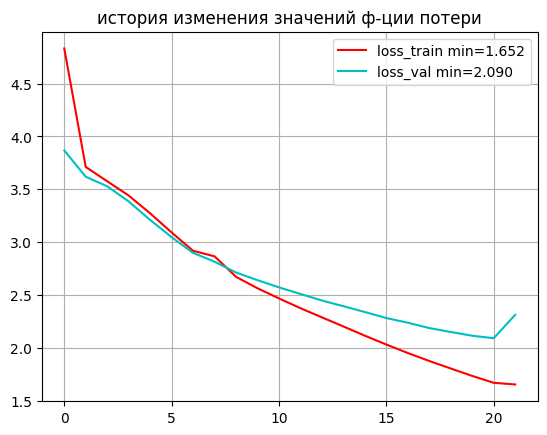

In [50]:
# история изменения значений ф-ции потери
plt.plot(loss_history_train,label='loss_train min=%.3f'%(min(loss_history_train)),c='r')
plt.plot(loss_history_val,label='loss_val min=%.3f'%(min(loss_history_val)),c='c')
plt.grid()
plt.title('история изменения значений ф-ции потери')
plt.legend()

# Тестируем

In [51]:
# from nltk.translate.bleu_score import sentence_bleu
from torchtext.data.metrics import bleu_score

In [52]:
def decode(code,voc): return ' '.join([ voc[c] for c in code if c!=0 ])

In [53]:
voc_ru = { v:k for k,v in ds_train.vocab['Rus'].items() }
voc_en = { v:k for k,v in ds_train.vocab['Eng'].items() }

### на учебном наборе

In [54]:
%%time 

init_seq = []
hypothesis = []
reference = []

with torch.set_grad_enabled(False):
    for input_tensor, target_tensor in DataLoader( ds_train, batch_size=batch_size, shuffle=False): 
        encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
        init_seq.append( input_tensor.cpu().numpy() )
        
        reference.append( target_tensor.cpu().numpy() )
        
        hypothesis.append( 
            np.swapaxes(np.argmax(
                decoder_outputs.cpu().numpy()
                ,axis=-1,keepdims=True),2,1)
        )

init_seq = np.vstack( init_seq )        
reference = np.vstack( reference )
hypothesis = np.vstack( hypothesis )

display( init_seq.shape, reference.shape, hypothesis.shape, )

(84146, 10)

(84146, 10)

(84146, 1, 10)

CPU times: user 26.8 s, sys: 2.96 s, total: 29.8 s
Wall time: 29.8 s


In [55]:
%%time 

display( bleu_score( reference.astype(str) , hypothesis.astype(str) ) )

0.32486021518707275

CPU times: user 19.5 s, sys: 13.3 ms, total: 19.5 s
Wall time: 19.7 s


In [56]:
df_train_  = pd.DataFrame({
        'Rus': [ decode( v , voc_ru ) for v in tqdm( init_seq) ],
        'Eng_target': [ decode( v , voc_en ) for v in tqdm(reference) ],
        'Eng_predicted': [ decode( v , voc_en ) for v in tqdm( np.squeeze(hypothesis)) ],
    })

display( df_train_.sample(17) )

  0%|          | 0/84146 [00:00<?, ?it/s]

  0%|          | 0/84146 [00:00<?, ?it/s]

  0%|          | 0/84146 [00:00<?, ?it/s]

,Rus,Eng_target,Eng_predicted
43829,Вам нравится моя новая <UNK> шляпа ? <EOS>,Do you like my new straw hat ? <EOS>,Do you like a new new ? ? <EOS>
27399,Мы были <UNK> . <EOS>,We were passengers . <EOS>,We were . . <EOS>
58434,Как долго ты проработал в Бостоне ? <EOS>,How long did you work in Boston ? <EOS>,How long will you live in ? ? <EOS>
51831,Мистер Джонс в офисе ? <EOS>,Is Mr Jones in the office ? <EOS>,Is there this in this room ? <EOS>
50538,Какая минимальная зарплата в вашей стране ? <EOS>,What 's the minimum salary in your country ? <...,What 's the minimum salary in this ? ? <EOS>
69434,Это было <UNK> покупкой . <EOS>,It was an impulse buy . <EOS>,It was a book . . <EOS>
21606,Моя собака была серьёзно больна . <EOS>,My pet dog was seriously ill . <EOS>,My mother was was n't . . <EOS>
1039,Я был глубоко потрясён этим известием . <EOS>,I was <UNK> disturbed by this news . <EOS>,I was very in by this . . <EOS>
59368,Из комнаты никому не выходить . <EOS>,Do n't anybody leave this room . <EOS>,You n't believe to Tom . . <EOS>
8670,Мне нужно много книг . <EOS>,I need many books . <EOS>,I I need more questions . <EOS>


In [57]:
del init_seq
del hypothesis
del reference

### на тестовом наборе

In [58]:
ds_test = TextPairDataset(df_test, vocab=ds_train.vocab)

  0%|          | 0/10388 [00:00<?, ?it/s]

  0%|          | 0/10388 [00:00<?, ?it/s]

In [59]:
%%time 

init_seq = []
hypothesis = []
reference = []

with torch.set_grad_enabled(False):
    for input_tensor, target_tensor in DataLoader( ds_test, batch_size=batch_size, shuffle=False): 
        encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
        init_seq.append( input_tensor.cpu().numpy() )
        
        reference.append( target_tensor.cpu().numpy() )
        
        hypothesis.append( 
            np.swapaxes(np.argmax(
                decoder_outputs.cpu().numpy()
                ,axis=-1,keepdims=True),2,1)
        )

init_seq = np.vstack( init_seq )        
reference = np.vstack( reference )
hypothesis = np.vstack( hypothesis )

display( init_seq.shape, reference.shape, hypothesis.shape, )

(10388, 10)

(10388, 10)

(10388, 1, 10)

CPU times: user 3.35 s, sys: 436 ms, total: 3.79 s
Wall time: 3.78 s


In [60]:
%%time 

display( bleu_score( reference.astype(str) , hypothesis.astype(str) ) )

0.2609897553920746

CPU times: user 2.34 s, sys: 0 ns, total: 2.34 s
Wall time: 2.34 s


In [61]:
df_test_  = pd.DataFrame({
        'Rus': [ decode( v , voc_ru ) for v in tqdm( init_seq) ],
        'Eng_target': [ decode( v , voc_en ) for v in tqdm(reference) ],
        'Eng_predicted': [ decode( v , voc_en ) for v in tqdm( np.squeeze(hypothesis)) ],
    })

display( df_test_.sample(17) )

  0%|          | 0/10388 [00:00<?, ?it/s]

  0%|          | 0/10388 [00:00<?, ?it/s]

  0%|          | 0/10388 [00:00<?, ?it/s]

,Rus,Eng_target,Eng_predicted
1298,Что ты с ними сделал ? <EOS>,What have you done with them ? <EOS>,What do you done to us ? <EOS>
484,У меня кончились деньги . <EOS>,I have run out of money . <EOS>,have to to of . . <EOS>
5155,Автобус был пустой . <EOS>,The bus was empty . <EOS>,The The plane was . . <EOS>
4800,Я стоял в ожидании автобуса . <EOS>,I stood waiting for a bus . <EOS>,I was to for the car . <EOS>
9192,Вы можете объяснить мне дорогу ? <EOS>,Can you explain the way to me ? <EOS>,you give me money me ? ? <EOS>
6874,Сегодня она принесла ему обед . <EOS>,She brought his lunch today . <EOS>,She She has her job . . <EOS>
4988,"Я думаю , что ты слишком сильно пытаешься . <EOS>",I think you 're trying too hard . <EOS>,I think you can too too . . <EOS>
6486,"Не думаю , что это честно . <EOS>",I do n't think it 's fair . <EOS>,I do n't think it 's . . <EOS>
1583,Почему они до сих пор здесь ? <EOS>,Why are they still here ? <EOS>,Why Why are we still ? ? <EOS>
2115,В последний раз я видел их в Албании . <EOS>,I last saw them in Albania . <EOS>,I I I should to the last Boston . <EOS>


In [62]:
del init_seq
del hypothesis
del reference

---

In [ ]:
# from torchtext.data.metrics import bleu_score

# candidate_corpus = [
#     ['My', 'full', 'pytorch', 'test'], 
#     ['Another', 'Sentence']
# ]

# references_corpus = [
#     [
#         ['My', 'full', 'pytorch', 'test'], 
#         ['Completely', 'Different']
#     ], [
#         ['No', 'Match']
#     ]
# ]

# bleu_score(candidate_corpus, references_corpus)

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu

# hypothesis = ['It', 'is', 'a', 'cat', 'at', 'room']
# reference = ['It', 'is', 'a', 'cat', 'inside', 'the', 'room']

# # hypothesis = [ '0', '1', '2', '3', '4', '6']
# # reference = [ '0', '1', '2', '3',  '5', '7', '6' ]

# bleu_score([hypothesis], [[reference,]])